In [64]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
using Roots
using Plots
using StatsFuns
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary  
# include("../model_MC.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

compute_higher_derivs

In [52]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [53]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .5, .8, 1., 2.]
x3 = [0., .8, 1., 1.6, 2.]
x4 = [0., 1., 1.6, 2.]

# testing
x01 = .25
x02 = 1.2
x03 = .5
x04 = .6

# underlying 1d function
test_fun1(x) = sin(x) + 1.1
test_fun2(x) = sin(15*x) + (x^2+1) 
test_fun3(x) = log(x^2+1) + (x^3+x+1)/(exp(x)) 

test_fun3 (generic function with 1 method)

# Summary
**Settings parameters**: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data
test_fun: underlying function

**Tests**:
1. p=1 or p=2, x=x1, x0=x01, test_fun=test_fun1 \
    narrow pdf, some quantile comp hard ==> bracketing interval $[0,5]$ works well!
2. p=1, x2, x02, test_fun2 \
    pdf very large near 0, so 2.5% quantile estimation gives negative estimate, which is not a good guess and also indicates that 2.5% quantile is extremely small. 
3. p=1, x3, x03, test_fun3 \
    narrow pdf, median hard ==> bracketing interval $[0,5]$ works well! \
    cdf(0) = 0.02898, 2.5% quantile doesn't exist
4. p=1, x4, x04, test_fun1 \
    two-peak pdf, can do mode, some quantile, but two-peak makes computation of CI (equal and narrow) super hard.
    
**Conclusion**:
1. Narrow pdf is the hardest case. Even if quant0 provides relatively good initial guess, find_zero easily goes to negative region, where CDF is not defined. \
Solution: bracketing interval works better than initial guess in root-finding
2. cdf(0) > 2.5% makes 2.5% quantile doesn't exist          
3. Weird shape: large pdf near 0 and two-peak pdf should be carefully treated. 
 

In [54]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x3 # choose training data 
x0 = x03 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.5]
Covariates at x0: [1.0]
Should expect peak near [0.752260142876725]


In [65]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 100]
rangeλ = [0.5 5]

btg1 = btg(trainingData1, rangeθ, rangeλ;  quadtype = "MonteCarlo")
weightTensorGrid = weight_comp(btg1)
pdf, cdf, dpdf, quantInfo = solve(btg1);

In [66]:
btg2 = btg(trainingData1, rangeθ, rangeλ)
weightTensorGrid2 = weight_comp(btg2)
pdf2, cdf2, dpdf2, quantInfo2 = solve(btg2);

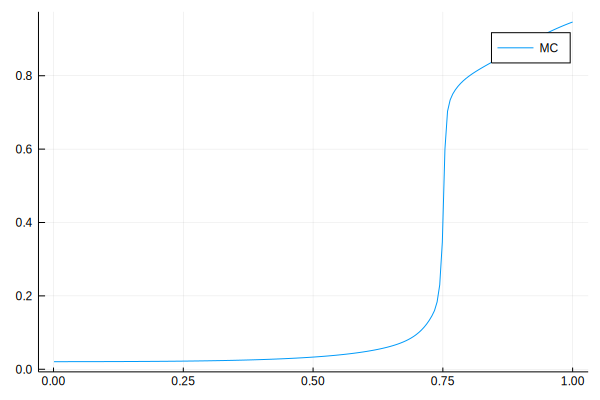

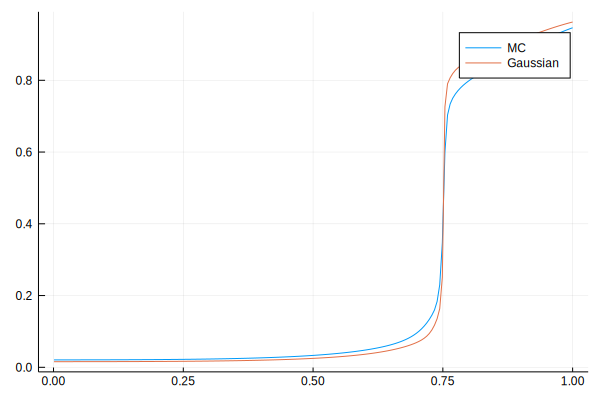

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.015685749781056794, 0.01568925400857548, 0.0156930241013191, 0.01569718763435476, 0.015701768467086288, 0.01570678100140715, 0.01571223858151636, 0.015718155148077805, 0.0157245456248207, 0.015731425991852867  …  0.9429844354343865, 0.9453905483663285, 0.9477425724020795, 0.9500376577789001, 0.9522731720554354, 0.9544467329440799, 0.9565562365906066, 0.9585998807202362, 0.9605761822139336, 0.9624839888459842])

In [75]:
# Plot to see the shape of pdf and cdf
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)
dpdf_fixed2 = y0 -> dpdf2(x0, Fx0, y0) 
pdf_fixed2 = y0 -> pdf2(x0, Fx0, y0)
cdf_fixed2 = y0 -> cdf2(x0, Fx0, y0)
a = 1e-3; b = 1.
plt(cdf_fixed, a, b, 200, label = "MC")
# plt!(dpdf_fixed, a, b, 200)
plt!(cdf_fixed2, a, b, 200, label = "Gaussian")
# plt!(pdf_fixed, a, b, 200, title = "PDF and CDF of Bayesian Predictive Distribution")

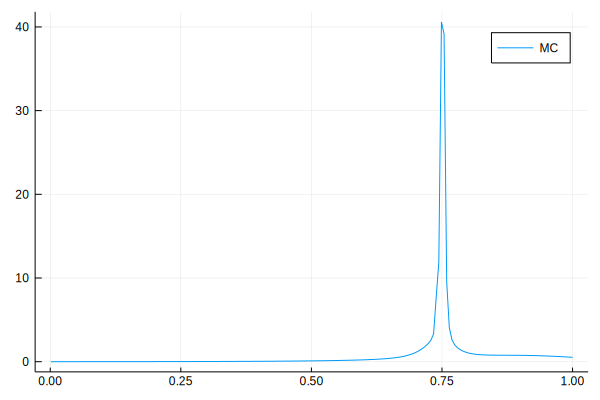

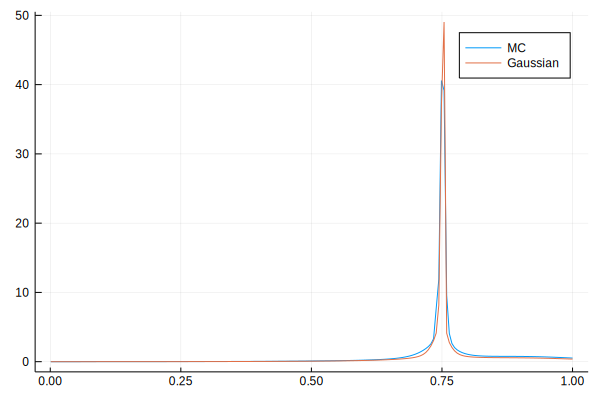

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.0007275950502830581, 0.0007152289837251189, 0.0007890247238020494, 0.0008704027809806131, 0.0009550538900049426, 0.0010423707280474356, 0.0011323822997766084, 0.0012252636465200856, 0.0013212226477475274, 0.0014204699364260163  …  0.48448439531269016, 0.4740064020332193, 0.46294147288029824, 0.45132935939566055, 0.4392167621763028, 0.4266564899482224, 0.4137064904798276, 0.40042877929585347, 0.3868882975617175, 0.37315173407326296])

In [76]:
plt(pdf_fixed, a, b, 200, label = "MC")
# plt!(dpdf_fixed, a, b, 200)
plt!(pdf_fixed2, a, b, 200, label = "Gaussian")
# plt!(pdf_fixed, a, b, 200, title = "PDF and CDF of Bayesian Predictive Distribution")

# Quantile computation

In [22]:
include("test_quantile.jl")
include("../statistics.jl")

credible_interval (generic function with 3 methods)

In [24]:
# preprocess output from solve(btg)
pdf_fixed, cdf_fixed, dpdf_fixed, quant0, support = pre_process(x0, Fx0, pdf, cdf, dpdf, quantInfo[1]);
println("Estimated support of pdf: $support")

Estimated support of pdf: [0.001, 5.0]


In [30]:
px = 0.5
quant_px, error = quantile(pdf_fixed, cdf_fixed, quant0, support; p=px)
# quant_0 = Roots.fzero(y-> cdf_fixed(y) - 0.5, 0, 5)

(0.7516435601383098, 1.1546319456101628e-14)

In [31]:
med, error = median(pdf_fixed, cdf_fixed, quant0, support)

(0.7516435601383098, 1.1546319456101628e-14)

In [32]:
mod = mode(pdf_fixed, cdf_fixed, support)

0.7519502392507109

In [33]:
confidence_level = .95
CI_equal, error = credible_interval(pdf_fixed, cdf_fixed, quant0, support; 
    mode=:equal, wp = confidence_level)

([0.5391954963529525, 1.0251573064691393], 0.0)

In [34]:
CI_narrow, error = credible_interval(pdf_fixed, cdf_fixed, quant0, support;
    mode=:narrow, wp = confidence_level)

([0.6043200586272098, 1.0645647011015364], 1.2669069653008748e-8)